# Population model simulator - demo

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch as th
from simulator.population_model import PopulationModel
from simulator.multi_armed_bandits import EpsilonGreedy, UCB, simulate, orders_and_rate_per_day
from simulator.plotting import plot_average_rewards


## Generate a population model

The agents have the following features:
- **buy intention**: the intention of a client to buy the product, modeled using a Beta distribution with $\alpha=2$, $\beta=7$.
$\alpha$ models the number of successes and $\beta$ the number of failures. The default case assumes that the mean value is around 0.22, with a low variance. If you want the model to be more concentrated towards 1, set $\alpha > \beta$.
- **client**: whether the agent is a new or existing client, modeled using Bernoulli with a probability of $25\%$ that a client is an existing one.
- **visit count**: represents the number of visits and is modeled using a Negative Binomial. It has as parameters total_count (the number of total trials or failures after which the process stops) and probs (the probability of success). total_counts is set to 1 and probability of success is correlated with the buy_intention modeled by a Beta distribution

Each sampling from the population requires a given discount that the clients see at that moment.

In [ ]:
# initialize a population with the default parameters
pop_model = PopulationModel.init()

In [6]:
# customize the parameters for the distributions
alpha = 5.0 # must be float
beta = 5.0 # must be float
probs_client = 0.1
visits_total_count = 1

In [8]:
# initialize a population with the customized parameters
pop_model = PopulationModel.init(alpha=alpha,\
                                 beta=beta, \
                                 probs_client=probs_client, \
                                 visits_total_count=visits_total_count )

### Fit the model to have the desired buy rate

In [9]:
# 0.8% of clients buy something, change if a different target is needed
pop_model.fit(target = 0.008) 
pop_model.save_weights("new_weights.pth")

000000) ratio=0.402, loss=0.76  |  tensor([ 1.04,  0.38, -1.52, -1.60, -1.26, -0.22, -0.81,  1.74])
001000) ratio=0.223, loss=0.34  |  tensor([ 0.44,  0.81, -0.86, -2.06, -1.35,  0.21, -0.47,  2.22])
002000) ratio=0.117, loss=0.17  |  tensor([ 0.08,  0.66, -0.36, -2.27, -0.85,  0.06, -0.65,  2.79])
003000) ratio=0.060, loss=0.09  |  tensor([-0.27,  0.53,  0.10, -2.48, -0.34, -0.07, -0.90,  3.27])
004000) ratio=0.049, loss=0.07  |  tensor([-0.61,  0.45,  0.45, -2.65,  0.09, -0.15, -1.14,  3.68])
005000) ratio=0.033, loss=0.06  |  tensor([-0.91,  0.42,  0.73, -2.80,  0.50, -0.18, -1.32,  4.02])
006000) ratio=0.022, loss=0.05  |  tensor([-1.18,  0.41,  0.96, -2.95,  0.91, -0.19, -1.46,  4.30])
007000) ratio=0.012, loss=0.04  |  tensor([-1.42,  0.38,  1.12, -3.04,  1.25, -0.22, -1.58,  4.57])
008000) ratio=0.020, loss=0.05  |  tensor([-1.64,  0.37,  1.25, -3.14,  1.59, -0.23, -1.65,  4.79])
009000) ratio=0.024, loss=0.06  |  tensor([-1.80,  0.35,  1.33, -3.21,  1.87, -0.25, -1.68,  4.97])


### Population model with 0.8% buy rate

In [2]:
# load the pretrained weights for a population model that had 0.8% buy rate, with the default parameters
# pop_model.load_weights("weights_population_model_0.8_ratio.pth")


## Population model analysis

### The population model distribution for intention, visits count

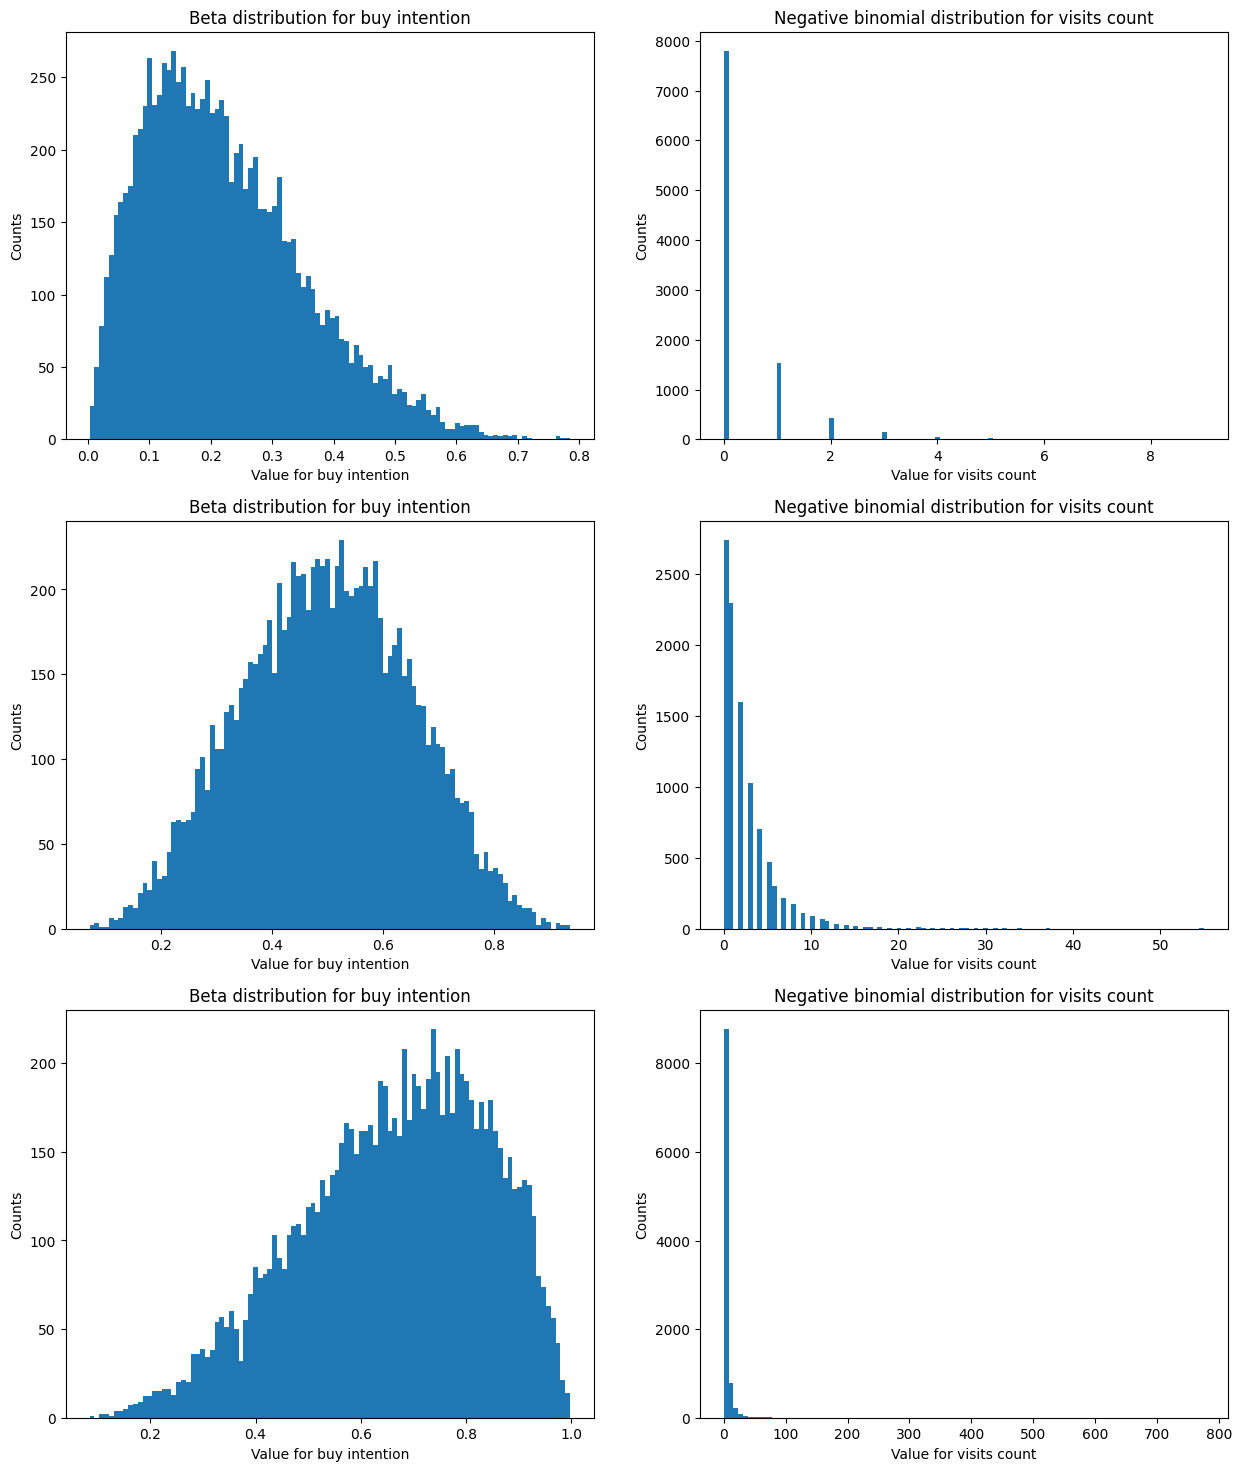

In [29]:
parameters_combinations = [
    {'alpha':2.0, 'beta':7.0, 'probs_client':0.25, 'visits_total_count':1},
    {'alpha':5.0, 'beta':5.0, 'probs_client':0.1, 'visits_total_count':2},
    {'alpha':4.0, 'beta':2.0, 'probs_client':0.5, 'visits_total_count':1}
]
fig, axes = plt.subplots(3, 2, figsize=(15, 18))  
for i, parameters in enumerate(parameters_combinations):
    pop_model = PopulationModel.init(alpha=parameters['alpha'],\
                                    beta=parameters['beta'], \
                                    probs_client=parameters['probs_client'], \
                                    visits_total_count=parameters['visits_total_count'] )

    sampled_features = pop_model.sample(discount=0.2, N=10000)
    intention_values = sampled_features[:, 0].detach().numpy()
    client_values = sampled_features[:, 1].detach().numpy()
    visits_count_values = sampled_features[:, 2].detach().numpy()

    axes[i,0].hist(intention_values, bins=100)
    axes[i,0].set_title("Beta distribution for buy intention")
    axes[i,0].set_xlabel("Value for buy intention")
    axes[i,0].set_ylabel("Counts")
    axes[i,1].hist(visits_count_values, bins=100)
    axes[i,1].set_title("Negative binomial distribution for visits count")
    axes[i,1].set_xlabel("Value for visits count")
    axes[i,1].set_ylabel("Counts")

### Buy decision rate function with respect to discount over 1000 samples

In [31]:
pop_model = PopulationModel.init()
pop_model.load_weights("weights_population_model_0.8_ratio.pth")

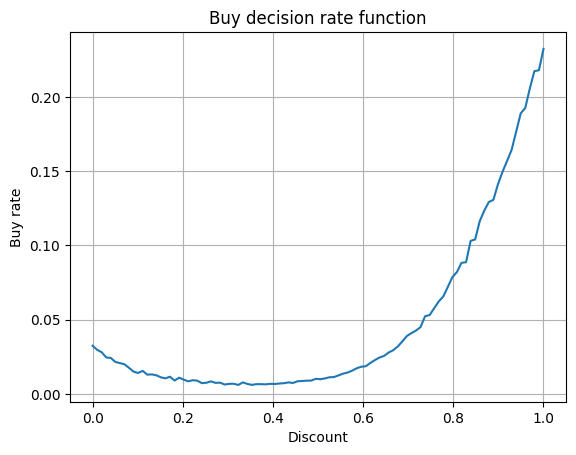

In [32]:
discounts = np.linspace(0.0, 1.0, 100)  

sigmoid_outputs = []

N = 1000

for discount in discounts:
    # sample N set of features with a specified discount 
    sampled_features = pop_model.sample(discount=discount, N=N)
    
    # create polynomial features for the samples 
    k = pop_model.weights.shape[0] // sampled_features.shape[1]  
    phi = pop_model._make_features(sampled_features, k)
    
    sigmoid_output = th.sigmoid(phi @ pop_model.weights).detach().numpy()
    
    # compute the mean of the sigmoid outputs for the N samples with the specified discount
    sigmoid_outputs.append(np.mean(sigmoid_output))

plt.plot(discounts, sigmoid_outputs)
plt.title("Buy decision rate function")
plt.xlabel("Discount")
plt.ylabel("Buy rate")
plt.grid(True)
plt.savefig("plots/new_buy_probability_correlated_with_discount.png")
plt.show()

### Buy decision rate function with respect to buy_intention and is_client over 1000 samples

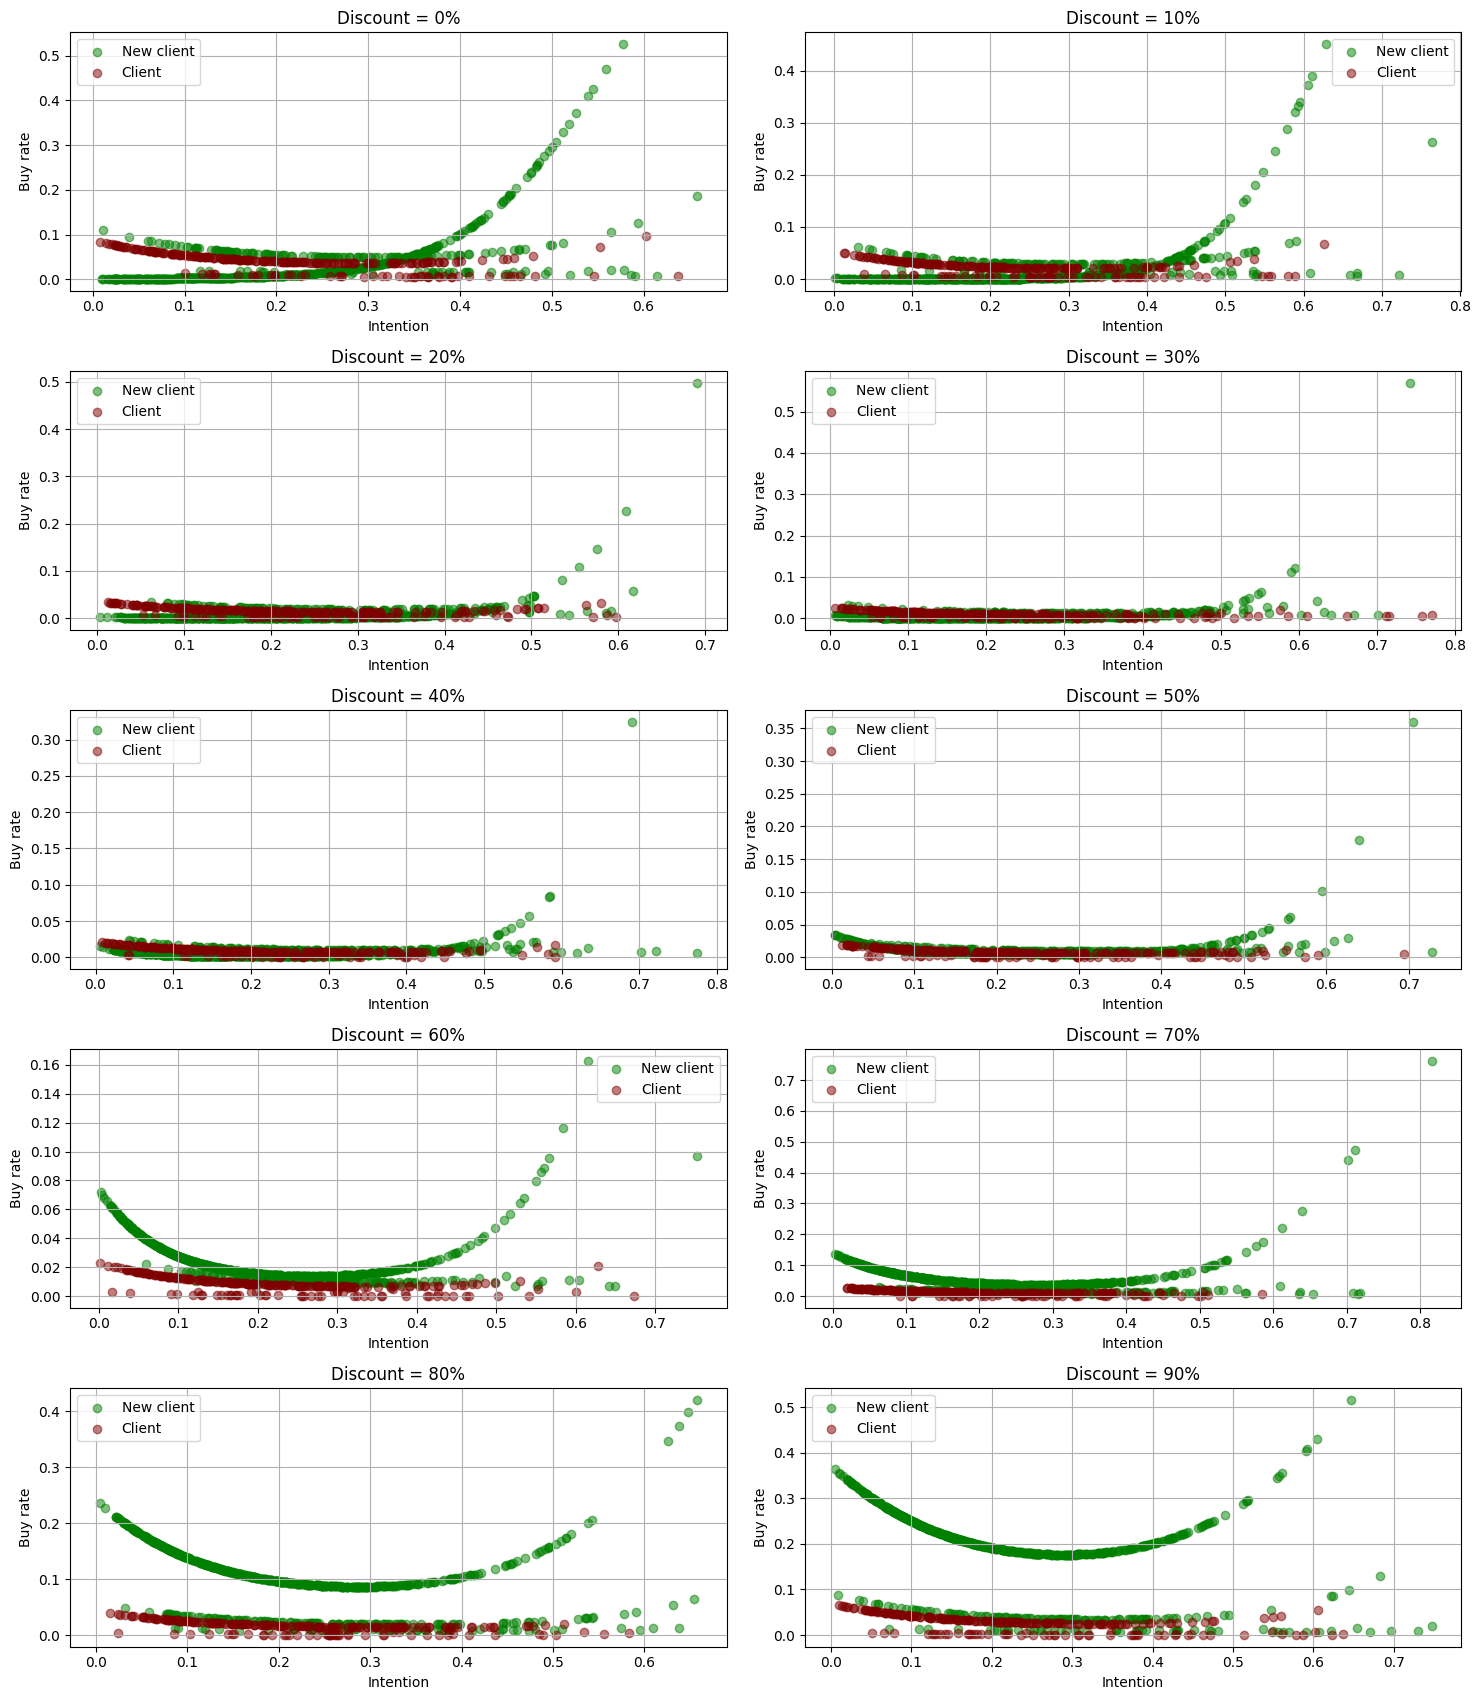

In [33]:
discounts = np.linspace(0.0, 0.9, 10)

fig, axes = plt.subplots(5, 2, figsize=(15, 18))  
axes = axes.flatten()

N = 1000  

for i, discount in enumerate(discounts):
    # sample N set of features with a specified discount 
    sampled_features = pop_model.sample(discount=discount, N=N)
    
    # extract the values for the features buy_intention and client (whether it's an existing client or not)
    intention_values = sampled_features[:, 0].detach().numpy()
    client_values = sampled_features[:, 1].detach().numpy()

    # create polynomial features for the samples 
    k = pop_model.weights.shape[0] // sampled_features.shape[1]
    phi = pop_model._make_features(sampled_features, k)
    sigmoid_outputs = th.sigmoid(phi @ pop_model.weights).detach().numpy()

    non_clients = client_values == 0
    clients = client_values == 1
    
    # plot for each discount the correlation between buy rate and buy intention, coloured by the client feature
    axes[i].scatter(intention_values[non_clients], sigmoid_outputs[non_clients], 
                    color='green', label='New client', alpha=0.5)
    axes[i].scatter(intention_values[clients], sigmoid_outputs[clients], 
                    color='maroon', label='Client', alpha=0.5)
    axes[i].set_title(f"Discount = {discount*100:.0f}%")
    axes[i].set_xlabel("Intention")
    axes[i].set_ylabel("Buy rate")
    axes[i].grid(True)
    axes[i].legend()


plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.savefig("plots/new_buy_probability_correlated_wth_intention_discount_and_client.png")
plt.show()

### Epsilon Greedy over 100 steps - maximize rate

In [ ]:
features = plot_average_rewards(pop_model, n_days=360, confidences=[1, 2, 3], num_runs=30, \
                                discounts=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8], \
                                reward='profit')

100%|██████████| 30/30 [00:37<00:00,  1.24s/it]


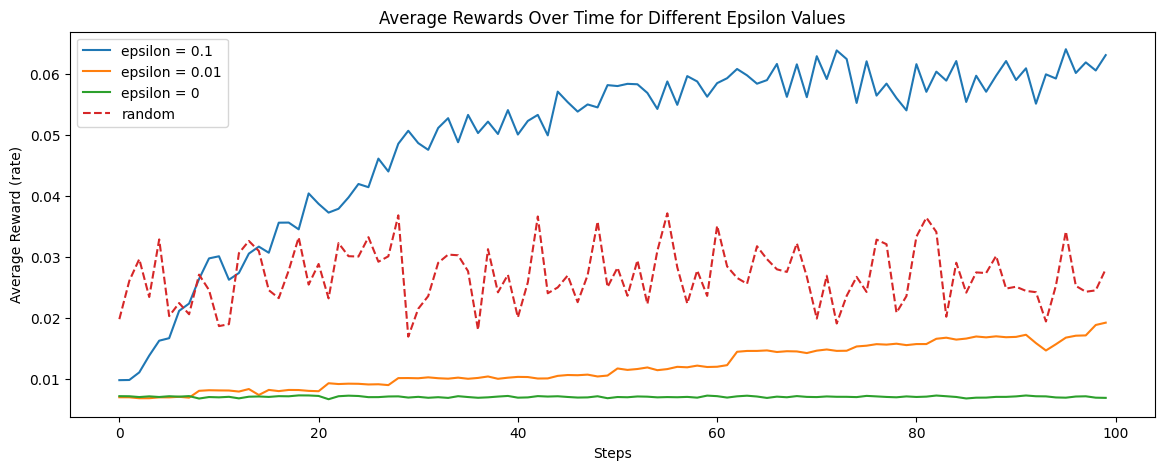

<Figure size 640x480 with 0 Axes>

In [4]:
features = plot_average_rewards(pop_model, n_days=100, epsilons=[0.1, 0.01, 0], confidences=[], num_runs=30,\
      discounts=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8], reward='rate')

In [5]:
features

[{'rewards_random': array([0.01979608, 0.02606863, 0.02964118, 0.02342353, 0.03286078,
         0.02029412, 0.02243725, 0.02059804, 0.02709216, 0.02456471,
         0.0186549 , 0.01897843, 0.03060784, 0.03261176, 0.03096667,
         0.02454314, 0.02323922, 0.02777647, 0.03319608, 0.02546078,
         0.02883922, 0.0232    , 0.03226275, 0.03011373, 0.03005882,
         0.03323333, 0.02920588, 0.03009412, 0.0368098 , 0.01692549,
         0.02149804, 0.02357255, 0.02902745, 0.03037647, 0.03026471,
         0.0276549 , 0.0180549 , 0.03127059, 0.02418824, 0.02707843,
         0.02008627, 0.02583726, 0.03662353, 0.02403726, 0.02499216,
         0.02695098, 0.02257843, 0.02699608, 0.03579804, 0.02505098,
         0.02823529, 0.02363137, 0.02943725, 0.02227255, 0.03099412,
         0.03714314, 0.02829216, 0.02235882, 0.02778431, 0.02360588,
         0.03511373, 0.0284451 , 0.02655882, 0.0255902 , 0.03174902,
         0.02963137, 0.02796275, 0.02753922, 0.03222941, 0.02677451,
         0.01988

### Epsilon Greedy and UCB - maximize orders

100%|██████████| 30/30 [00:37<00:00,  1.26s/it]


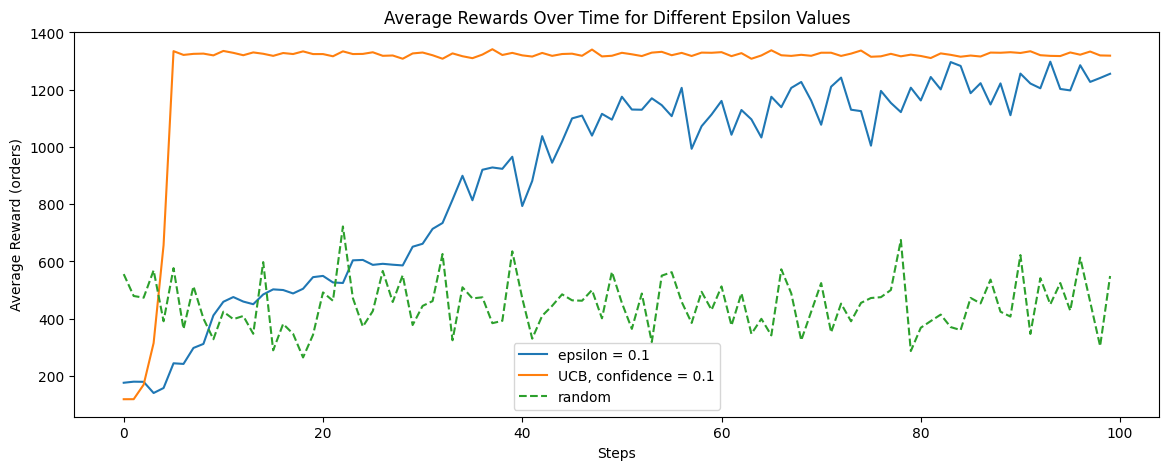

<Figure size 640x480 with 0 Axes>

In [7]:
features = plot_average_rewards(pop_model, n_days=100, epsilons=[0.1], confidences=[2], num_runs=30,\
      discounts=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8], reward='orders')

In [8]:
features

[{'rewards_random': array([555.76666667, 479.4       , 473.46666667, 569.06666667,
         391.06666667, 576.76666667, 364.3       , 513.26666667,
         400.7       , 328.3       , 424.63333333, 398.5       ,
         409.56666667, 347.36666667, 597.8       , 289.6       ,
         381.76666667, 347.23333333, 264.7       , 343.7       ,
         491.9       , 462.7       , 722.26666667, 472.03333333,
         372.5       , 426.66666667, 566.9       , 458.4       ,
         551.8       , 378.        , 444.83333333, 461.53333333,
         626.        , 324.76666667, 509.83333333, 470.96666667,
         474.8       , 384.43333333, 392.63333333, 635.46666667,
         471.56666667, 330.33333333, 410.3       , 444.96666667,
         485.2       , 464.3       , 462.8       , 500.06666667,
         401.36666667, 563.53333333, 455.13333333, 364.5       ,
         488.06666667, 318.06666667, 550.4       , 562.5       ,
         459.        , 385.26666667, 494.        , 430.76666667,
       

### Epsilon Greedy and UCB - maximize profit

100%|██████████| 30/30 [00:43<00:00,  1.46s/it]


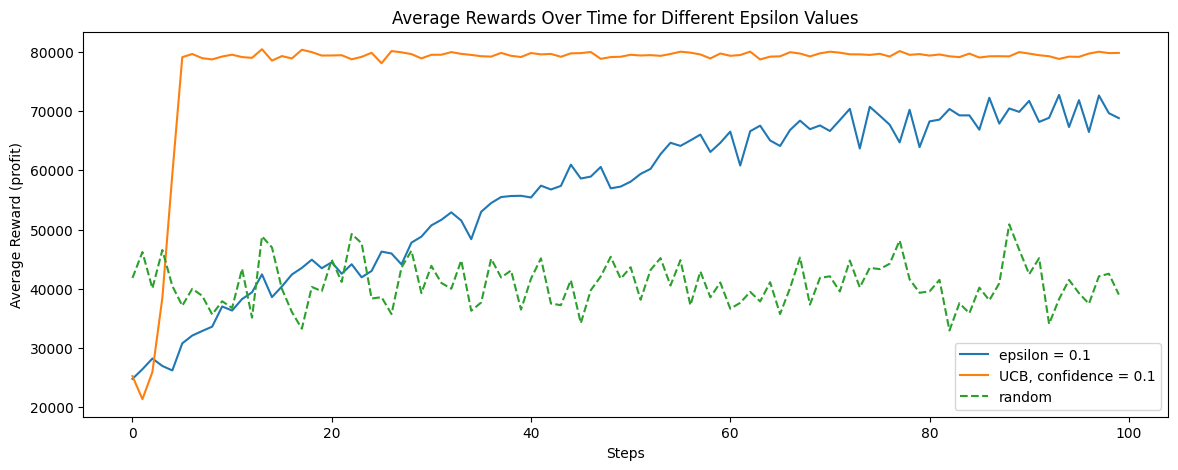

<Figure size 640x480 with 0 Axes>

In [9]:
features = plot_average_rewards(pop_model, n_days=100, epsilons=[0.1], confidences=[2], num_runs=30,\
      discounts=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8], reward='profit')

In [10]:
features

[{'rewards_random': array([41831., 46208., 40069., 46546., 40480., 37140., 39999., 38823.,
         35670., 37899., 36768., 43376., 35130., 48864., 46980., 39974.,
         36077., 33268., 40315., 39599., 44913., 41164., 49249., 47700.,
         38356., 38592., 35730., 43586., 46432., 39289., 43882., 40994.,
         40009., 44807., 36299., 37692., 45072., 41912., 43097., 36489.,
         41716., 45141., 37516., 37238., 41464., 34192., 39765., 42095.,
         45405., 41710., 43642., 38157., 43185., 45184., 40557., 44836.,
         37218., 42930., 38564., 41066., 36635., 37638., 39486., 37867.,
         41114., 35745., 40122., 45286., 37337., 41837., 42111., 39547.,
         44769., 40237., 43542., 43323., 44233., 48158., 41610., 39328.,
         39565., 41508., 32967., 37568., 35885., 40198., 38058., 40932.,
         50881., 46603., 42456., 45180., 34068., 38258., 41508., 39259.,
         37483., 42105., 42548., 39023.]),
  'values_random': array([25017.72048764, 21349.57616611, 25348

100%|██████████| 30/30 [00:38<00:00,  1.30s/it]


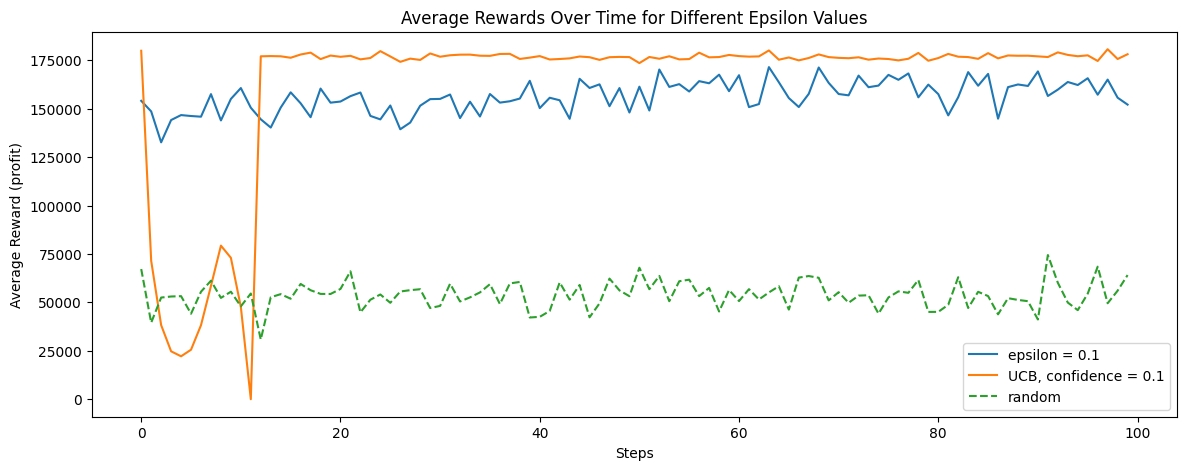

<Figure size 640x480 with 0 Axes>

In [11]:
features = plot_average_rewards(pop_model, n_days=100, epsilons=[0.1], confidences=[2], num_runs=30,\
      discounts=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1], reward='profit')

In [12]:
features

[{'rewards_random': array([67205.5, 39518. , 52493.5, 53040.5, 53217. , 44148.5, 55512.5,
         61189.5, 52316. , 55511.5, 47968.5, 54573.5, 30818.5, 52663. ,
         54259. , 51891.5, 59521.5, 56285. , 54381.5, 54345.5, 56950. ,
         66040.5, 44856. , 51372. , 54081.5, 49796.5, 55616.5, 56316.5,
         56790. , 47085. , 48188. , 59645.5, 50476.5, 52594.5, 55148. ,
         59408. , 49146.5, 59797.5, 60556. , 42194. , 42543.5, 45561. ,
         60323. , 51417.5, 58985.5, 42293. , 49505. , 62286.5, 56204.5,
         53195.5, 67896. , 56813.5, 63655. , 50612.5, 60904. , 61727. ,
         53233. , 57483. , 45297.5, 56394. , 50670.5, 56819. , 51499.5,
         55126. , 58365.5, 46285.5, 62789. , 63607.5, 62692. , 51033.5,
         55268.5, 49801. , 53490. , 53691. , 44198. , 52560. , 55687. ,
         54947.5, 61571. , 45085.5, 45109.5, 48757. , 62998. , 47102. ,
         55470. , 53253.5, 43834. , 52174. , 51268. , 50620.5, 41171. ,
         74444. , 60125. , 49901. , 45991.5, 5